In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbj.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbb_large.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / "symmetrized_HH4b.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

# shuffle the data
df_3b = df_3b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_bg4b = df_bg4b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_hh4b = df_hh4b.sample(frac=1, random_state=seed_).reset_index(drop=True)

3b-jet events:  275508
4b-jet events:  382108
HH4b-jet events:  28656


In [3]:
n_3b = 250000
n_all4b = 250000
signal_ratio = 0.1

In [4]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset

np.random.seed(seed_)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

# features = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
#             "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
#             "canJet0_phi", "canJet1_phi", "canJet2_phi", "canJet3_phi",
#             "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5

n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)


df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# reduce number of 4b samples to 1/8
print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

# For ghostbatch, let len(train_indices) be a multiple of 32
split_at = 1024 * (int((2/3) * df_train.index.size) // 1024)
end_at = 1024 * (df_train.index.size // 1024)

X_train = torch.tensor(df_train[features].values, dtype=torch.float32)[:split_at]
w_train = torch.tensor(df_train["weight"].values, dtype=torch.float32)[:split_at]
y_train = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[:split_at]
is_signal_train = torch.tensor(df_train["signal"].values, dtype=torch.long)[:split_at]

X_val = torch.tensor(df_train[features].values, dtype=torch.float32)[split_at:end_at]
w_val = torch.tensor(df_train["weight"].values, dtype=torch.float32)[split_at:end_at]
y_val = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[split_at:end_at]
is_signal_val = torch.tensor(df_train["signal"].values, dtype=torch.long)[split_at:end_at]

train_dataset = TensorDataset(X_train, y_train, w_train)
val_dataset = TensorDataset(X_val, y_val, w_val)


Seed set to 42


4b ratio:  0.49898747
Signal ratio:  0.099999994


In [5]:
from ancillary_features import PtEtaPhi_to_PxPyPz

# add Px, Py, Pz
for i in range(4):
    for prefix in ["sym_", ""]:
        phi = torch.tensor(df_train[f"{prefix}canJet{i}_phi"].values)
        eta = torch.tensor(df_train[f"{prefix}canJet{i}_eta"].values)
        pt = torch.tensor(df_train[f"{prefix}canJet{i}_pt"].values)
        px, py, pz = PtEtaPhi_to_PxPyPz(pt, eta, phi)
        df_train[f"{prefix}canJet{i}_px"] = px.numpy()
        df_train[f"{prefix}canJet{i}_py"] = py.numpy()
        df_train[f"{prefix}canJet{i}_pz"] = pz.numpy()

Before Considering Symmetry


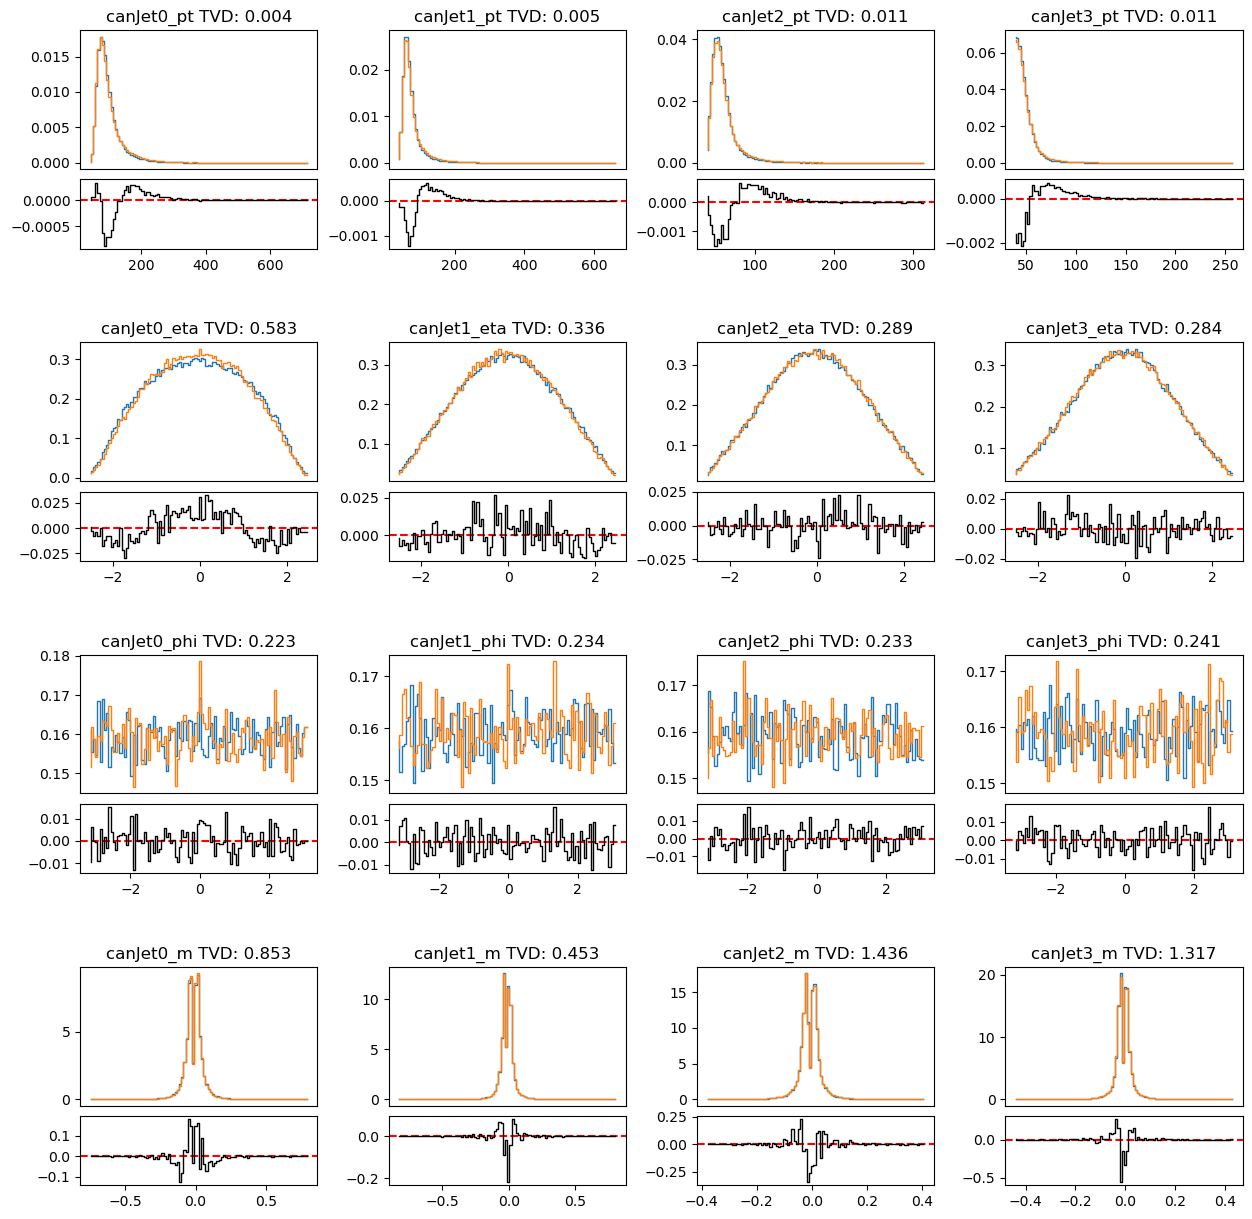

After Considering Symmetry


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_3649213/3728100400.py:67: RuntimeWarning: invalid value encountered in subtract
  tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
/tmp/ipykernel_3649213/3728100400.py:74: RuntimeWarning: invalid value encountered in subtract
  ratio = feat_hist_4b - feat_hist_3b


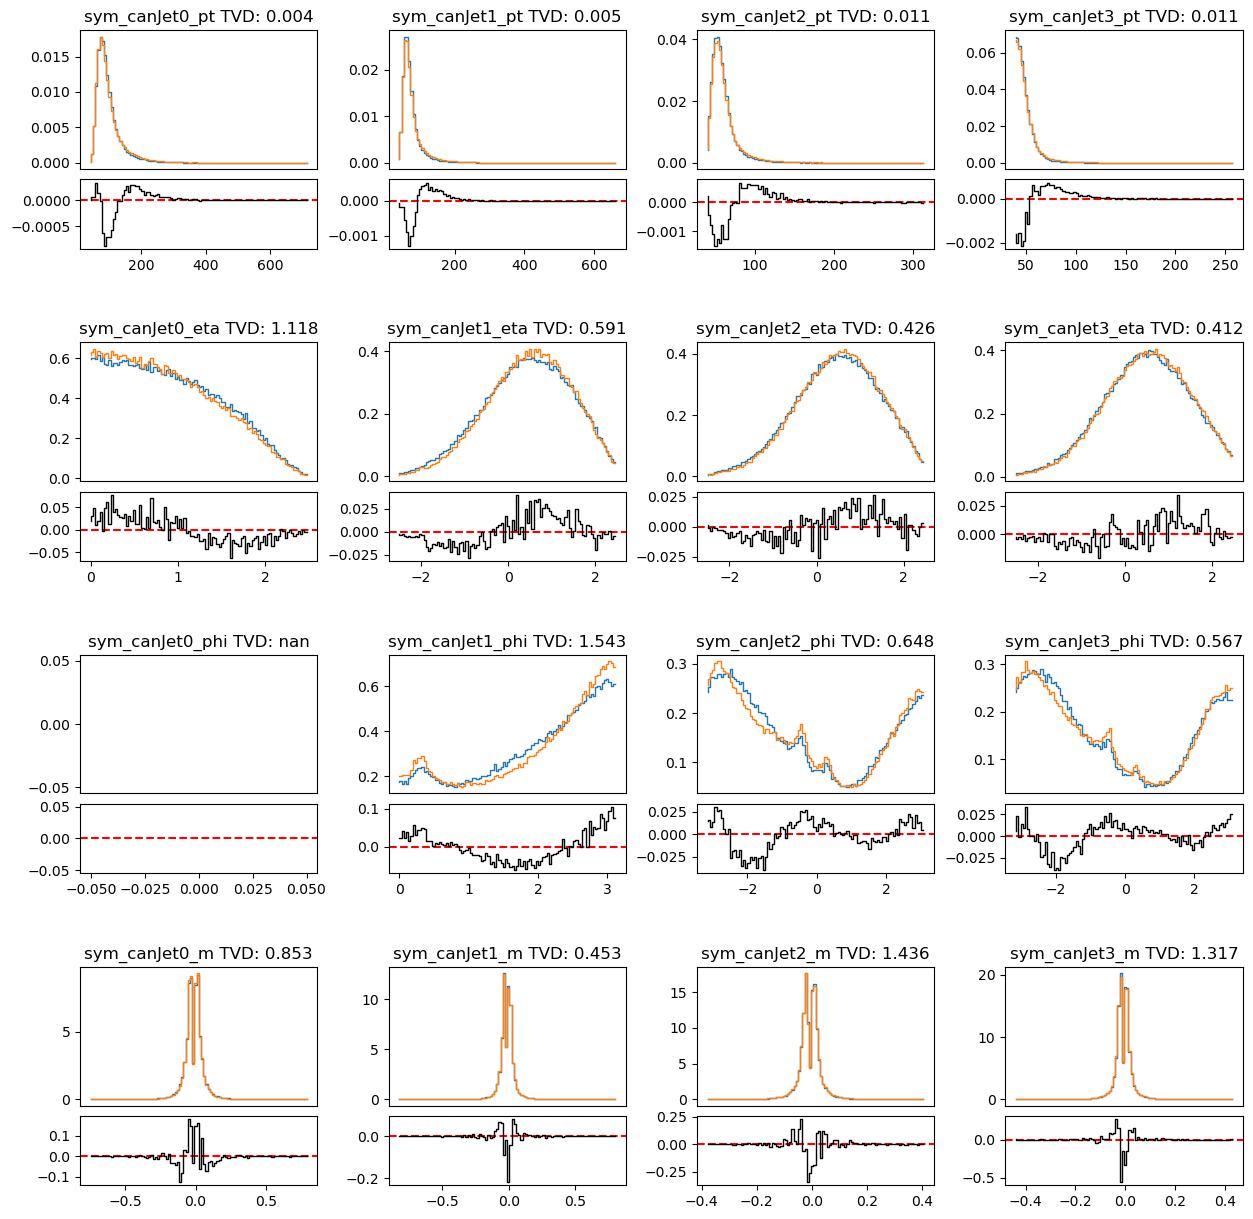

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)
is_4b = df_train["fourTag"]

                        

print("Before Considering Symmetry")
features_ptetaphi = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
                        "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
                        "canJet0_phi", "canJet1_phi", "canJet2_phi", "canJet3_phi",
                        "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]

for i in range(4):
    for j in range(4):
        feature = features_ptetaphi[i*4 + j]
        bins_range = np.linspace(df_train[feature].min(), df_train[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_train.loc[~is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[~is_4b, "weight"].values)
        feat_hist_4b, _ = np.histogram(df_train.loc[is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[is_4b, "weight"].values)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)


plt.show()
plt.close()

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)


features_ptetaphi = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
                        "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
                        "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
                        "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

print("After Considering Symmetry")

for i in range(4):
    for j in range(4):
        feature = features_ptetaphi[i*4 + j]
        bins_range = np.linspace(df_train[feature].min(), df_train[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_train.loc[~is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[~is_4b, "weight"].values)
        feat_hist_4b, _ = np.histogram(df_train.loc[is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[is_4b, "weight"].values)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)

plt.show()
plt.close()

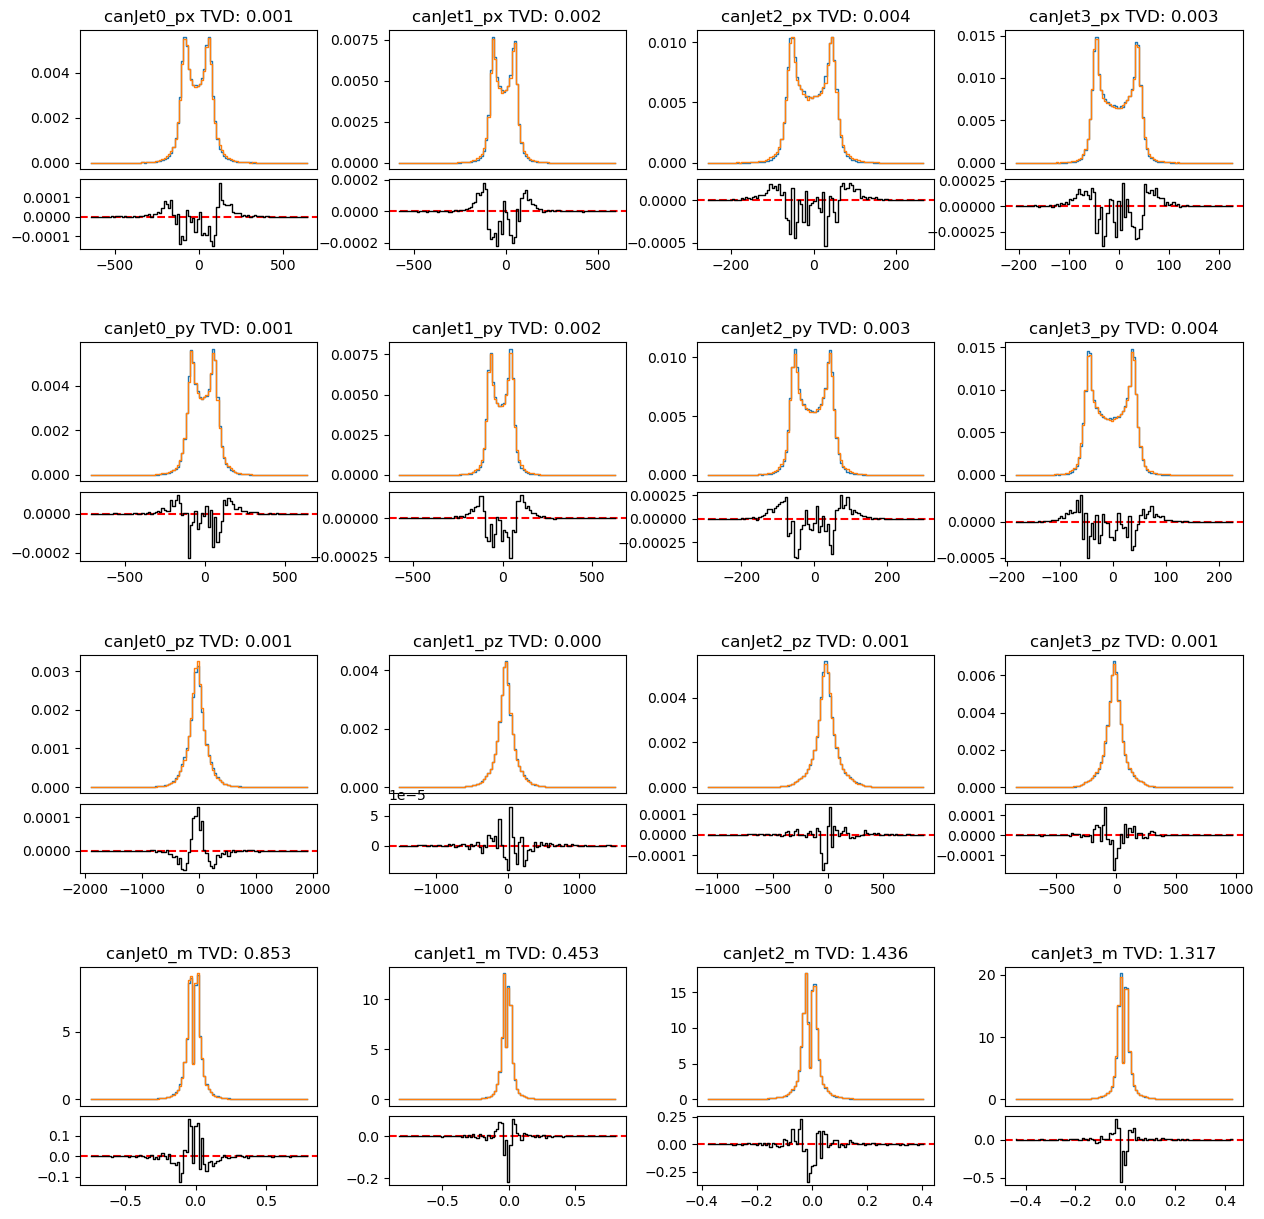

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(8, 4, hspace=1.5, wspace=0.3)
is_4b = df_train["fourTag"]

features_pxpypz = ["canJet0_px", "canJet1_px", "canJet2_px", "canJet3_px",
                   "canJet0_py", "canJet1_py", "canJet2_py", "canJet3_py",
                   "canJet0_pz", "canJet1_pz", "canJet2_pz", "canJet3_pz",
                     "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]
                   
for i in range(4):
    for j in range(4):
        feature = features_pxpypz[i*4 + j]
        bins_range = np.linspace(df_train[feature].min(), df_train[feature].max(), 100)
        feat_hist_3b, _ = np.histogram(df_train.loc[~is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[~is_4b, "weight"].values)
        feat_hist_4b, _ = np.histogram(df_train.loc[is_4b, feature].values, bins=bins_range, density=True, weights=df_train.loc[is_4b, "weight"].values)

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.1, height_ratios=[2, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.step(bins_range[:-1], feat_hist_3b, label="3b", linewidth=1)
        current_ax.step(bins_range[:-1], feat_hist_4b, label="4b", linewidth=1)
        # calculate distance between two histograms (total variation distance)
        tvd = 0.5 * np.sum(np.abs(feat_hist_3b - feat_hist_4b))
        current_ax.set_title(f"{feature} TVD: {tvd:.3f}")
        # remove x labels
        current_ax.set_xticks([])
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])
        ratio = feat_hist_4b - feat_hist_3b
        current_ax.axhline(0, color="red", linestyle="--")
        current_ax.step(bins_range[:-1], ratio, label="4b - 3b", linewidth=1, color="black")
        fig.add_subplot(current_ax)


plt.show()
plt.close()

In [8]:
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",])
lr = 1e-3


In [320]:
pl.seed_everything(42)

model = FvTClassifier(num_classes, 
                       dim_input_jet_features, 
                       dim_dijet_features, 
                       dim_quadjet_features, 
                       run_name=run_name,
                       device=torch.device("cuda:0"),
                       lr=lr)

model.fit(train_dataset, val_dataset, batch_size=1024, max_epochs=max_epochs)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 32/32 [00:01<00:00, 21.95it/s, v_num=0, val_loss=0.692, train_loss=0.691]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 32/32 [00:01<00:00, 20.20it/s, v_num=0, val_loss=0.692, train_loss=0.691]


In [ ]:
## SvB

pl.seed_everything(42)

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 80
svb_run_name = "_".join(["svb_classifier_toy_signal_ratio", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",])
lr = 1e-3


model = FvTClassifier(num_classes, 
                       dim_input_jet_features, 
                       dim_dijet_features, 
                       dim_quadjet_features, 
                       run_name=svb_run_name,
                       device=torch.device("cuda:0"),
                       lr=lr)


svb_train_dataset = TensorDataset(X_train, is_signal_train, w_train)
svb_val_dataset = TensorDataset(X_val, is_signal_val, w_val)

model.fit(svb_train_dataset, svb_val_dataset, batch_size=1024, max_epochs=max_epochs)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 79: 100%|██████████| 32/32 [00:01<00:00, 21.85it/s, v_num=0, val_loss=0.268, train_loss=0.291]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 32/32 [00:01<00:00, 21.34it/s, v_num=0, val_loss=0.268, train_loss=0.291]


In [9]:
from torch.utils.data import DataLoader


# model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{svb_run_name}_best.ckpt")
model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
model = model.to(device)

q_repr_val = []

for batch in val_loader:
    x, y, w = batch
    x = x.to(device)
    q = model.encoder(x)
    q_repr_val.append(q.detach().cpu().numpy())

q_repr_val = np.concatenate(q_repr_val, axis=0)
labels_4b_val = y_val.cpu().numpy()
probs_4b_val = model.predict(X_val)[:, 1].cpu().numpy()
weights_val = w_val.cpu().numpy()
is_signal_val = is_signal_val.cpu().numpy()

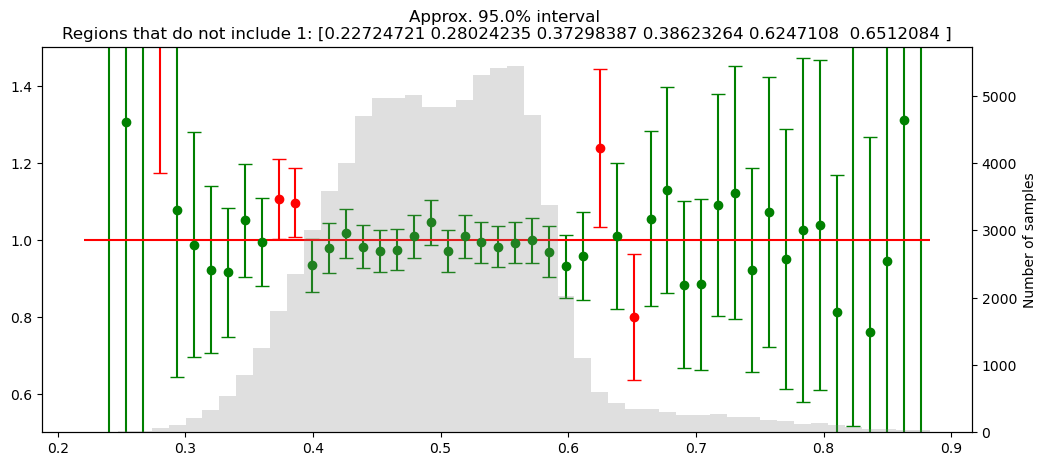

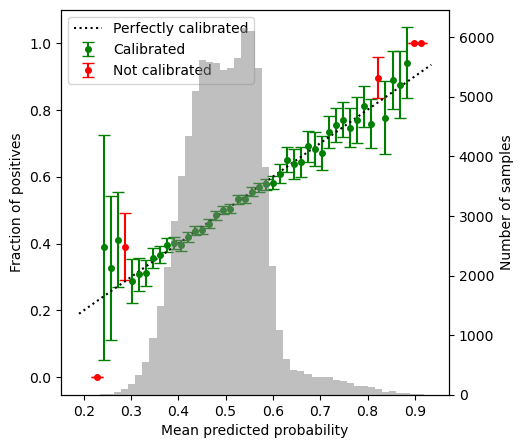

In [10]:
from plots import plot_prob_weighted_histogram1d, calibration_plot
%matplotlib inline
plot_prob_weighted_histogram1d(probs_4b_val, probs_4b_val, labels_4b_val,
                               n_bins=50, 
                               sample_weights=weights_val,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_val, labels_4b_val,
                 bins=50,
                 sample_weights=weights_val)

# plot_prob_weighted_histogram1d(probs_4b_val, probs_4b_val, is_signal_val,
#                                n_bins=50, 
#                                sample_weights=weights_val,
#                                ylim=(0.5, 1.5))
# calibration_plot(probs_4b_val, is_signal_val,
#                  bins=50,
#                  sample_weights=weights_val)

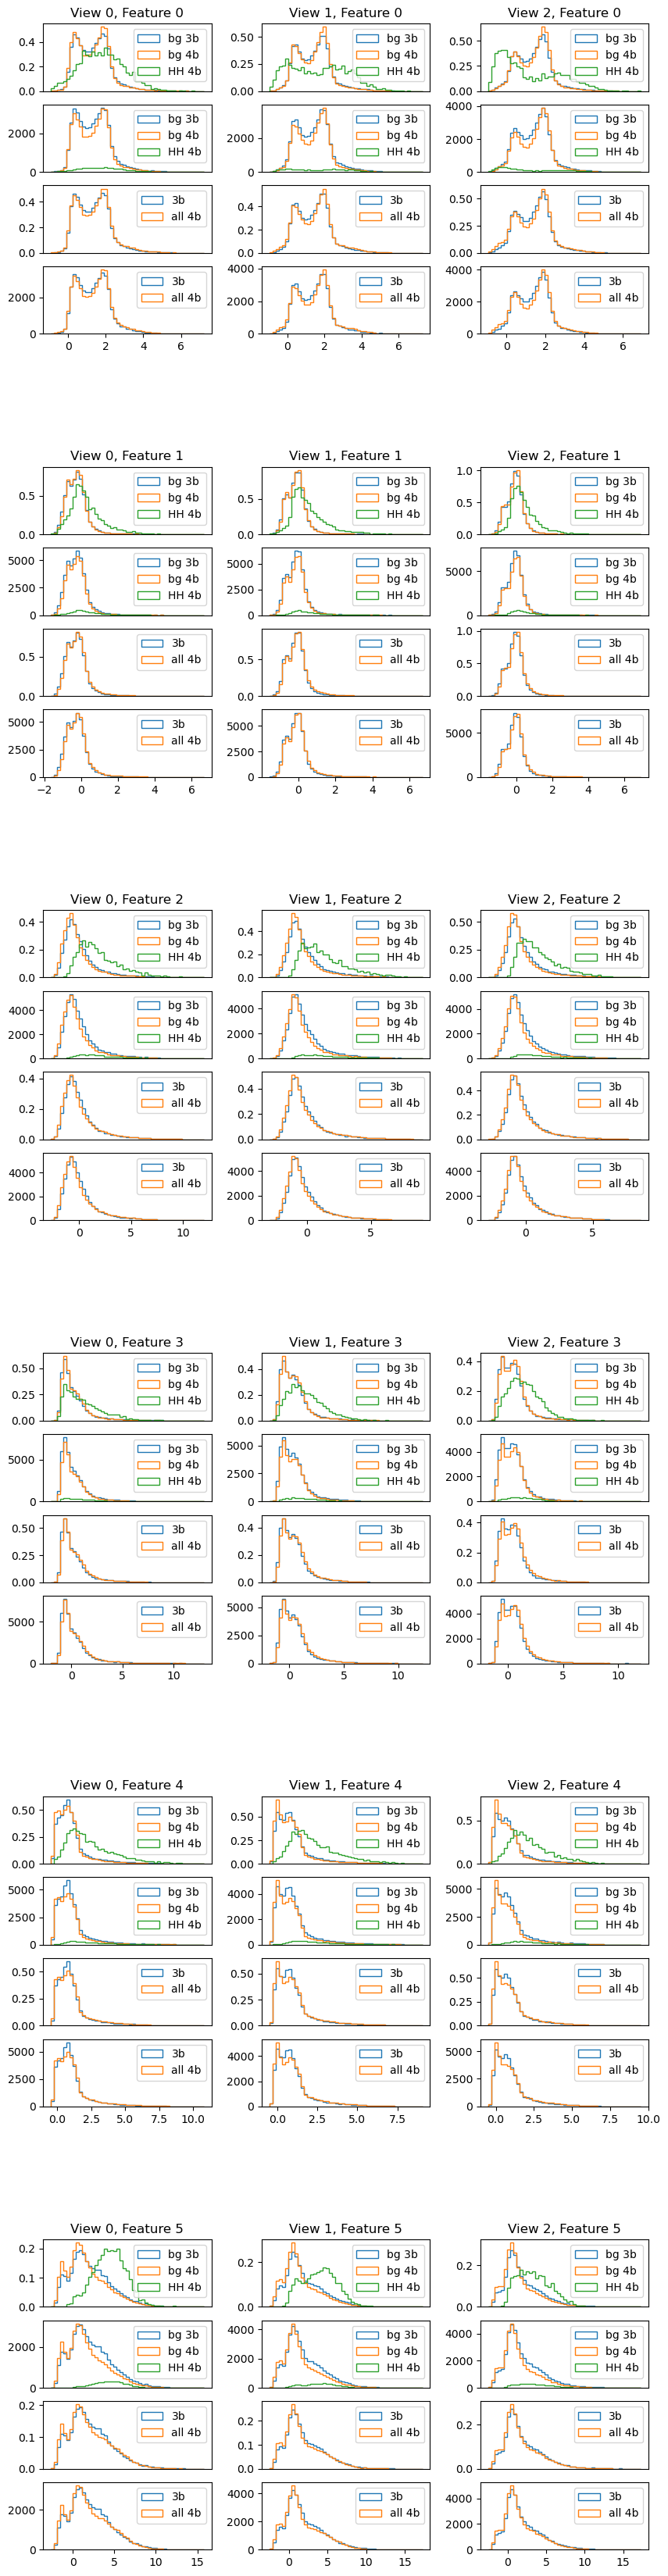

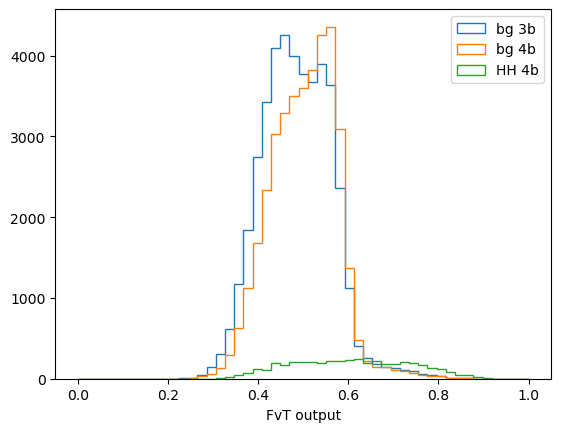

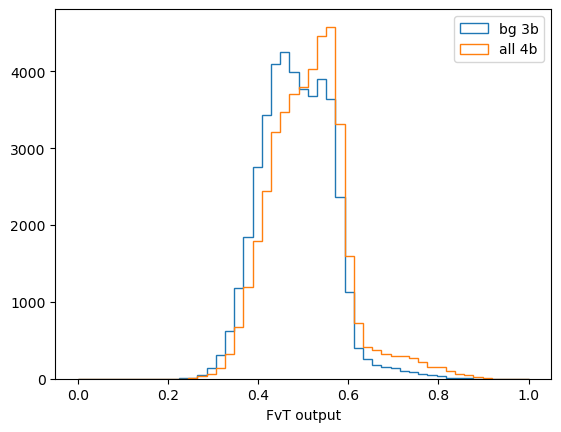

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)

is_3b_val = labels_4b_val == 0
is_4b_val = labels_4b_val == 1
is_bg4b_val = (labels_4b_val == 1) & (is_signal_val == 0)
is_hh4b_val = (labels_4b_val == 1) & (is_signal_val == 1)
plot_density = True

for i in range(dim_quadjet_features):
    for j in range(3):
        
        repr_min, repr_max = np.min(q_repr_val[:, i, j]), np.max(q_repr_val[:, i, j])
        bins_range = np.linspace(repr_min, repr_max, 50)
        
        inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.2, height_ratios=[1, 1, 1, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.hist(q_repr_val[is_3b_val, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=True, weights=weights_val[is_3b_val])
        current_ax.hist(q_repr_val[is_bg4b_val, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=True, weights=weights_val[is_bg4b_val])
        current_ax.hist(q_repr_val[is_hh4b_val, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=True, weights=weights_val[is_hh4b_val])
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])

        current_ax.hist(q_repr_val[is_3b_val, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_val[is_3b_val])
        current_ax.hist(q_repr_val[is_bg4b_val, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_bg4b_val])
        current_ax.hist(q_repr_val[is_hh4b_val, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_hh4b_val])
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        # current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[2])
        current_ax.hist(q_repr_val[is_3b_val, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=True, weights=weights_val[is_3b_val])
        current_ax.hist(q_repr_val[is_4b_val, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=True, weights=weights_val[is_4b_val])
        # calculate distance between two histograms (total variation distance)
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()

        fig.add_subplot(current_ax)
        current_ax = plt.Subplot(fig, inner[3])
        current_ax.hist(q_repr_val[is_3b_val, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=False, weights=weights_val[is_3b_val])
        current_ax.hist(q_repr_val[is_4b_val, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_4b_val])
        # calculate distance between two histograms (total variation distance)
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.legend()
        fig.add_subplot(current_ax)


plt.show()
plt.close()

bins_range = np.linspace(0, 1, 50)

fig, ax = plt.subplots()
ax.hist(probs_4b_val[is_3b_val], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_val[is_3b_val])
ax.hist(probs_4b_val[is_bg4b_val], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_bg4b_val])
ax.hist(probs_4b_val[is_hh4b_val], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_hh4b_val])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.hist(probs_4b_val[is_3b_val], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_val[is_3b_val])
ax.hist(probs_4b_val[is_4b_val], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_val[is_4b_val])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()


# Test dataset (Not validation dataset)

In [12]:
print("Test Data")

from torch.utils.data import DataLoader

end_at = 1024 * (df_test.index.size // 1024)

X_test = torch.tensor(df_test[features].values[:end_at], dtype=torch.float32)
w_test = torch.tensor(df_test["weight"].values[:end_at], dtype=torch.float32)
y_test = torch.tensor(df_test["fourTag"].values[:end_at], dtype=torch.long)
is_signal_test = torch.tensor(df_test["signal"].values[:end_at], dtype=torch.long)
svb_test_dataset = TensorDataset(X_test, y_test, w_test)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test = []

for batch in test_loader:
    x, y, w = batch
    x = x.to(device)
    q = fvt_model.encoder(x)
    q_repr_test.append(q.detach().cpu().numpy())

q_repr_test = np.concatenate(q_repr_test, axis=0)
labels_4b_test = y_test.cpu().numpy()
probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
weights_test = w_test.cpu().numpy()
is_signal_test = is_signal_test.cpu().numpy()

Test Data


**Test Data**


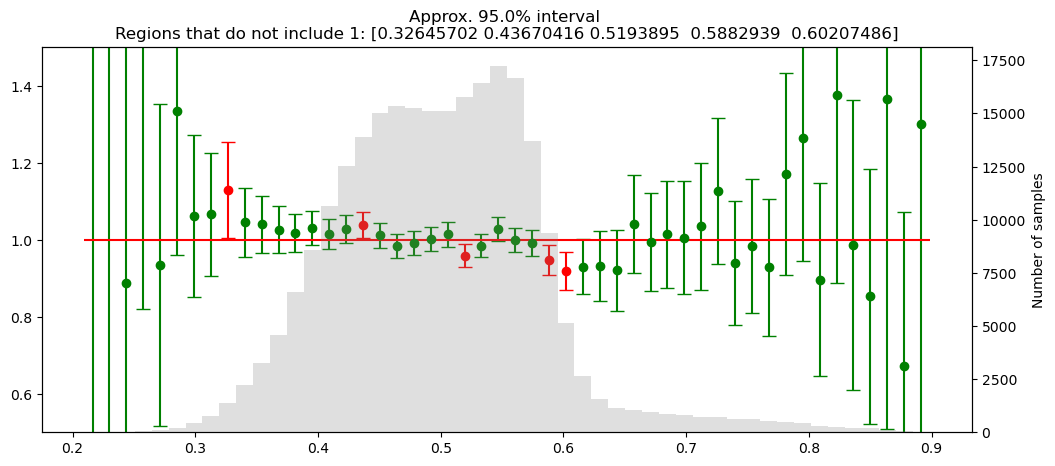

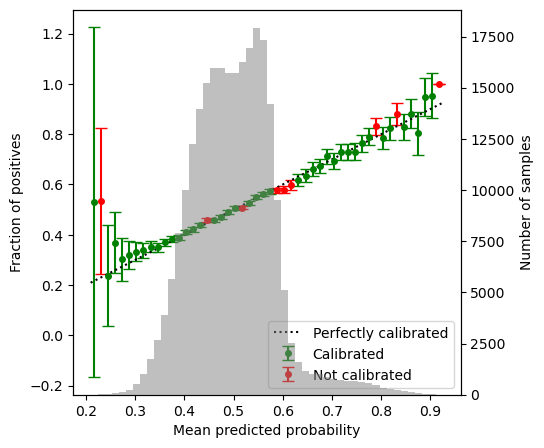

In [13]:
print("**Test Data**")


plot_prob_weighted_histogram1d(probs_4b_test, probs_4b_test, labels_4b_test,
                               n_bins=50, 
                               sample_weights=weights_test,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_test, labels_4b_test,
                 bins=50,
                 sample_weights=weights_test)

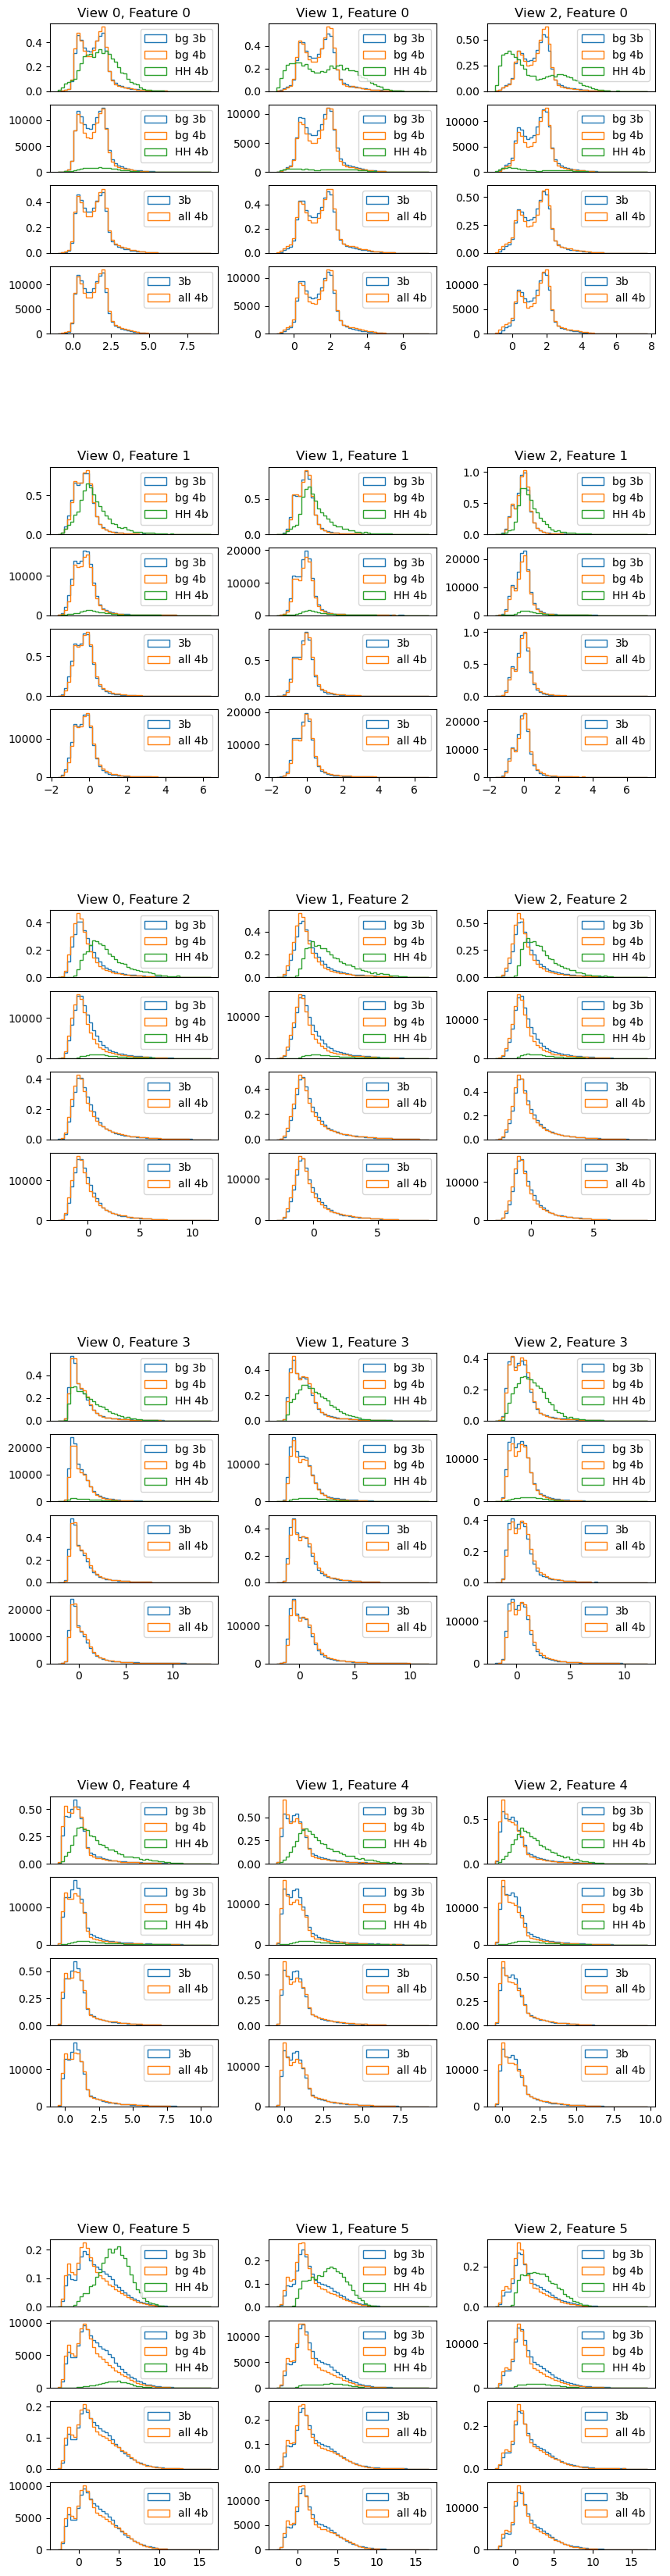

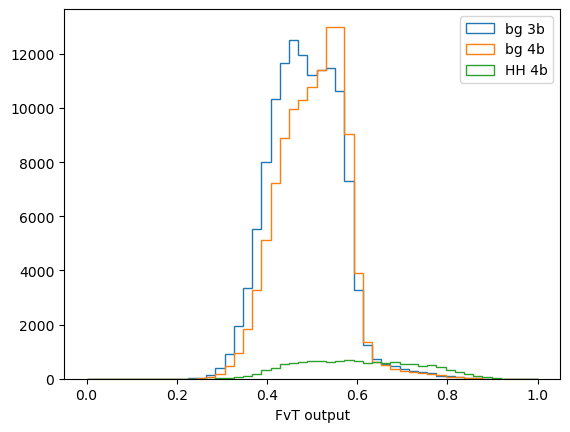

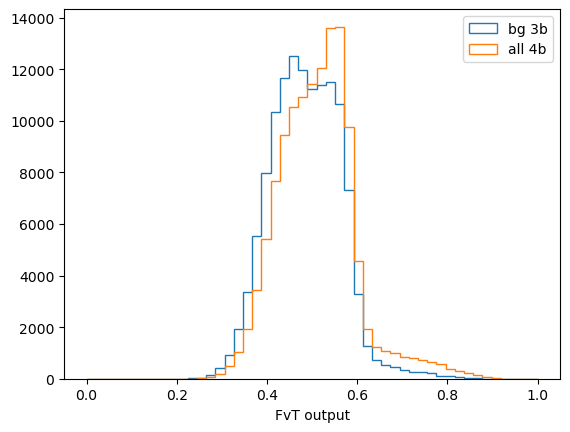

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)

is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)
plot_density = True

for i in range(dim_quadjet_features):
    for j in range(3):
        
        repr_min, repr_max = np.min(q_repr_test[:, i, j]), np.max(q_repr_test[:, i, j])
        bins_range = np.linspace(repr_min, repr_max, 50)
        
        inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.2, height_ratios=[1, 1, 1, 1])
        current_ax = plt.Subplot(fig, inner[0])
        current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
        current_ax.hist(q_repr_test[is_bg4b_test, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_bg4b_test])
        current_ax.hist(q_repr_test[is_hh4b_test, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_hh4b_test])
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[1])

        current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
        current_ax.hist(q_repr_test[is_bg4b_test, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
        current_ax.hist(q_repr_test[is_hh4b_test, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
        # calculate distance between two histograms (total variation distance)
        # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
        # current_ax.set_title(f"View {j}, Feature {i}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()
        fig.add_subplot(current_ax)

        current_ax = plt.Subplot(fig, inner[2])
        current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
        current_ax.hist(q_repr_test[is_4b_test, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_4b_test])
        # calculate distance between two histograms (total variation distance)
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.set_xticks([])
        current_ax.legend()

        fig.add_subplot(current_ax)
        current_ax = plt.Subplot(fig, inner[3])
        current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
        current_ax.hist(q_repr_test[is_4b_test, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_4b_test])
        # calculate distance between two histograms (total variation distance)
        # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
        # remove x labels
        current_ax.legend()
        fig.add_subplot(current_ax)


plt.show()
plt.close()

bins_range = np.linspace(0, 1, 50)

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_4b_test], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()


In [ ]:
# print("HH4B Data")
# from torch.utils.data import DataLoader

# end_at = 1024 * (df_hh4b.index.size // 1024)

# X_hh4b = torch.tensor(df_hh4b[features].values[:end_at], dtype=torch.float32)
# w_hh4b = torch.tensor(df_hh4b["weight"].values[:end_at], dtype=torch.float32)
# y_hh4b = torch.tensor(df_hh4b["fourTag"].values[:end_at], dtype=torch.long)
# is_signal_hh4b = torch.tensor(df_hh4b["signal"].values[:end_at], dtype=torch.long)
# hh4b_dataset = TensorDataset(X_hh4b, y_hh4b, w_hh4b)

# fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
# hh4b_loader = DataLoader(hh4b_dataset, batch_size=1024, shuffle=False)
# device = torch.device("cuda:0")
# fvt_model = fvt_model.to(device)

# q_repr_hh4b = []

# for batch in hh4b_loader:
#     x, y, w = batch
#     x = x.to(device)
#     q = fvt_model.encoder(x)
#     q_repr_hh4b.append(q.detach().cpu().numpy())

# q_repr_hh4b = np.concatenate(q_repr_hh4b, axis=0)
# labels_4b_hh4b = y_hh4b.cpu().numpy()
# probs_4b_hh4b = fvt_model.predict(X_hh4b)[:, 1].cpu().numpy()
# weights_hh4b = w_hh4b.cpu().numpy()
# is_signal_hh4b = is_signal_hh4b.cpu().numpy()

In [339]:
# tsne of q_repr_test

from sklearn.manifold import TSNE

np.random.seed(42)
# randomly sample 10k points
n_samples = 20000
sample_indices = np.random.choice(q_repr_test.shape[0], n_samples, replace=False)

sample_indices_1 = sample_indices[:n_samples // 2]
sample_indices_2 = sample_indices[n_samples // 2:]

q_repr_test_sample_1 = q_repr_test[sample_indices_1]
is_hh4b_test_sample_1 = is_hh4b_test[sample_indices_1]
is_bg4b_test_sample_1 = is_bg4b_test[sample_indices_1]
is_3b_test_sample_1 = is_3b_test[sample_indices_1]
is_4b_test_sample_1 = is_4b_test[sample_indices_1]

print("Signal ratio in test sample 1: ", np.sum(is_hh4b_test_sample_1) / (np.sum(is_4b_test_sample_1)))


q_repr_test_sample_2 = q_repr_test[sample_indices_2]
is_hh4b_test_sample_2 = is_hh4b_test[sample_indices_2]
is_bg4b_test_sample_2 = is_bg4b_test[sample_indices_2]
is_3b_test_sample_2 = is_3b_test[sample_indices_2]
is_4b_test_sample_2 = is_4b_test[sample_indices_2]

print("Signal ratio in test sample 2: ", np.sum(is_hh4b_test_sample_2) / (np.sum(is_4b_test_sample_2)))

Signal ratio in test sample 1:  0.1012555690562981
Signal ratio in test sample 2:  0.10049358341559723


In [ ]:
# cluster q_repr_test (Gaussian Mixture Model)

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

n_components = 10
gmm = GaussianMixture(n_components=n_components, random_state=seed_)



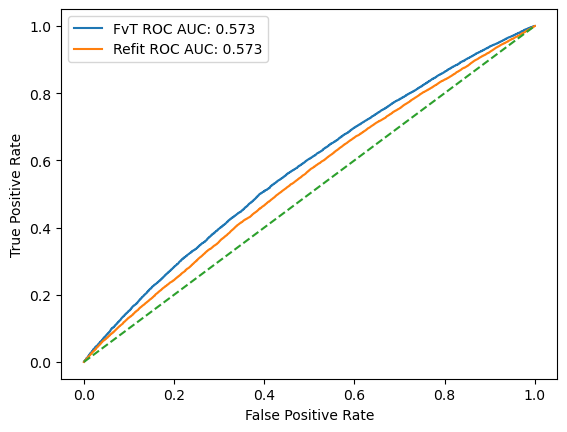

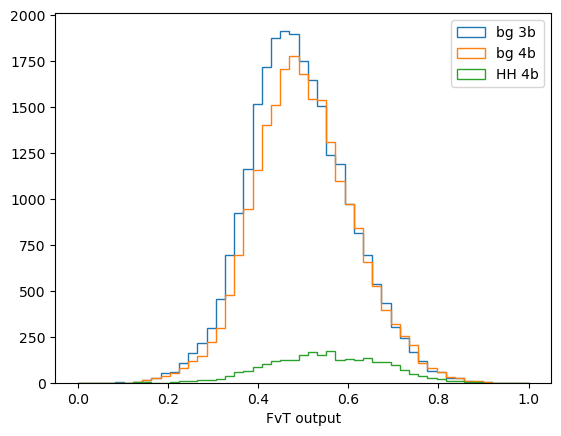

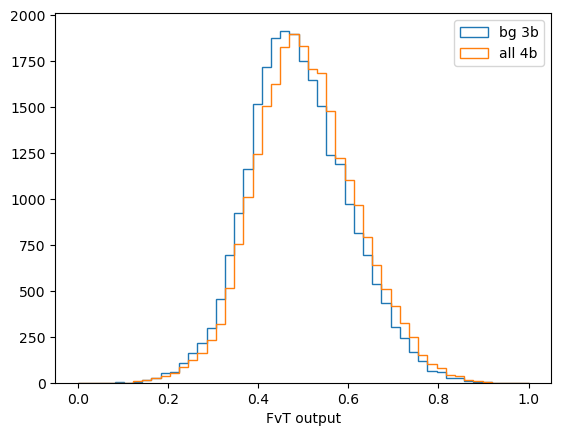

In [346]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(labels_4b_test, probs_4b_test, sample_weight=weights_test)
roc_auc = roc_auc_score(labels_4b_test, probs_4b_test, sample_weight=weights_test)

# refit

from xgboost import XGBClassifier

refit_clf = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05, n_jobs=4)
refit_clf.fit(q_repr_val.reshape(-1, 3*dim_quadjet_features), labels_4b_val, sample_weight=weights_val)

probs_4b_refit = refit_clf.predict_proba(q_repr_test.reshape(-1, 3*dim_quadjet_features))[:, 1]
auc_refit = roc_auc_score(labels_4b_test, probs_4b_refit)
fpr_refit, tpr_refit, _ = roc_curve(labels_4b_test, probs_4b_refit)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"FvT ROC AUC: {roc_auc:.3f}")
ax.plot(fpr_refit, tpr_refit, label=f"Refit ROC AUC: {roc_auc:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()
plt.close()

bins_range = np.linspace(0, 1, 50)

fig, ax = plt.subplots()
ax.hist(probs_4b_refit[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_refit[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
ax.hist(probs_4b_refit[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.hist(probs_4b_refit[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_refit[is_4b_test], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()


# Re-Fit Classifier

In [344]:
# fit a classifier on q_repr_test to predict 4b vs 3b

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# split the data
(q_repr_refit_train, q_repr_refit_val, 
 labels_4b_refit_train, labels_4b_refit_val, 
 is_3b_refit_train, is_3b_refit_val, 
 is_bg4b_refit_train, is_bg4b_refit_val, 
 is_hh4b_refit_train, is_hh4b_refit_val,
 weights_refit_train, weights_refit_val) = train_test_split(q_repr_test, 
                                                            labels_4b_test, 
                                                            is_3b_test, 
                                                            is_bg4b_test, 
                                                            is_hh4b_test, 
                                                            weights_test, 
                                                            test_size=0.25, random_state=seed_)
                                                                                         

refit_clf = GradientBoostingClassifier(n_estimators=10, max_depth=3, learning_rate=0.1)
refit_clf.fit(q_repr_refit_train.reshape(-1, 3*dim_quadjet_features), labels_4b_refit_train, sample_weight=weights_refit_train)

refit_probs_val = refit_clf.predict_proba(q_repr_refit_val.reshape(-1, 3*dim_quadjet_features))[:, 1]
refit_auc_val = roc_auc_score(labels_4b_refit_val, refit_probs_val)
fpr, tpr, _ = roc_curve(labels_4b_refit_val, refit_probs_val)

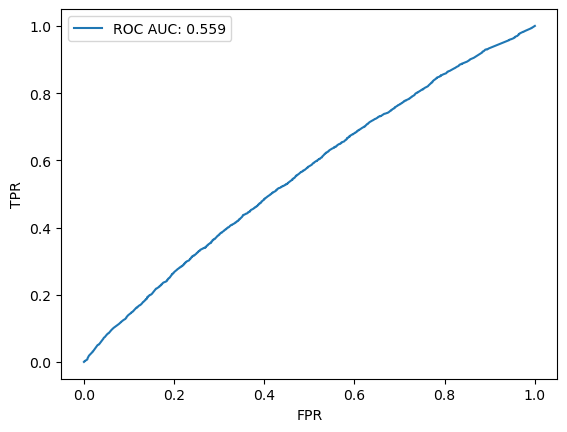

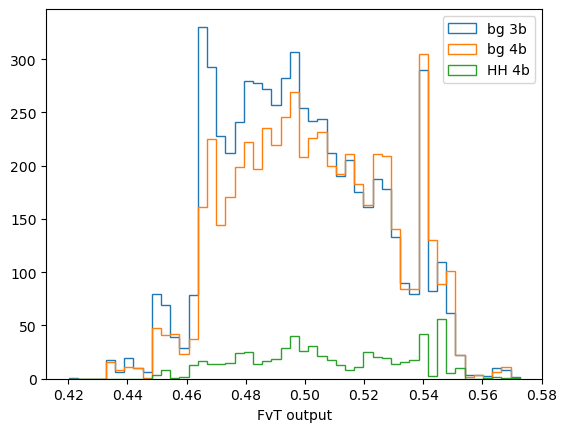

/tmp/ipykernel_2906762/2584694944.py:26: RuntimeWarning: invalid value encountered in divide
  refit_probs_val_hist_ratio = refit_probs_val_4b_hist / refit_probs_val_3b_hist


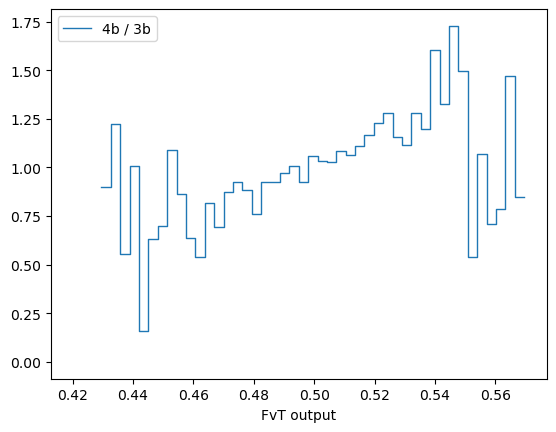

In [345]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC AUC: {refit_auc_val:.3f}")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend()
plt.show()
plt.close()

min_prob = refit_probs_val.min()
max_prob = refit_probs_val.max()
bins_range = np.linspace(min_prob, max_prob, 50)

fig, ax = plt.subplots()
ax.hist(refit_probs_val[is_3b_refit_val], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_refit_val[is_3b_refit_val])
ax.hist(refit_probs_val[is_bg4b_refit_val], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_refit_val[is_bg4b_refit_val])
ax.hist(refit_probs_val[is_hh4b_refit_val], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_refit_val[is_hh4b_refit_val])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

refit_probs_val_3b_hist, _ = np.histogram(refit_probs_val[is_3b_refit_val], bins=bins_range, density=False, weights=weights_refit_val[is_3b_refit_val])
refit_probs_val_4b_hist, _ = np.histogram(refit_probs_val[~is_3b_refit_val], bins=bins_range, density=False, weights=weights_refit_val[~is_3b_refit_val])


fig, ax = plt.subplots()
refit_probs_val_hist_ratio = refit_probs_val_4b_hist / refit_probs_val_3b_hist 
ax.step(bins_range[:-1], refit_probs_val_hist_ratio, label="4b / 3b", linewidth=1)
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()

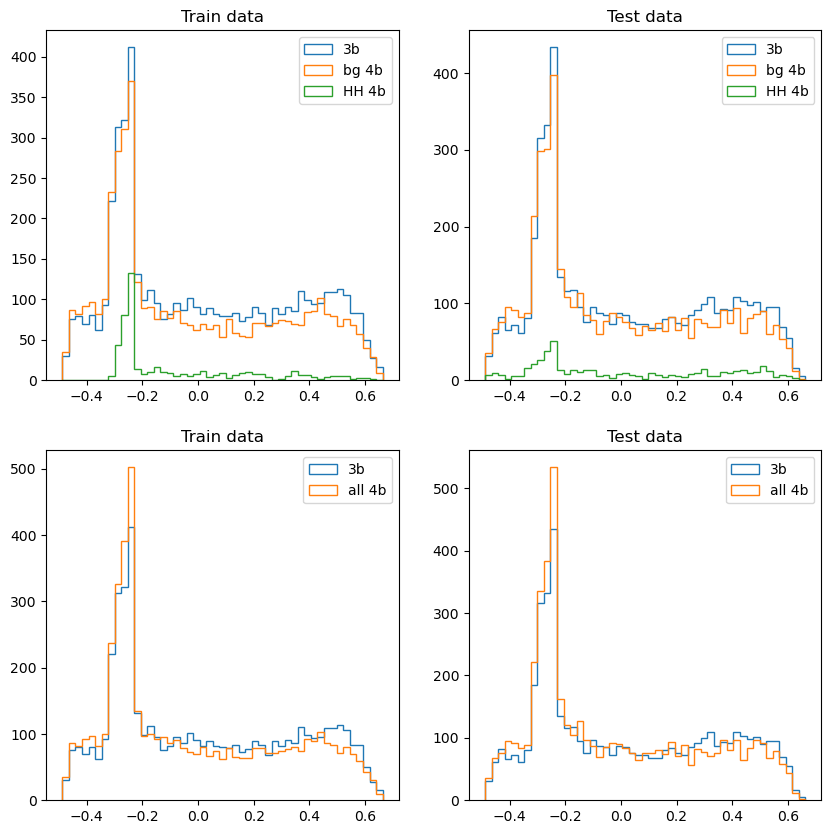

In [ ]:
# kernel PCA

from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=1, kernel="rbf", gamma=0.1, random_state=seed_)
q_repr_test_kpca_1 = kpca.fit_transform(q_repr_test_sample_1.reshape(-1, 3 * dim_quadjet_features))
# q_repr_hh4b_kpca = kpca.transform(q_repr_hh4b.reshape(-1, 3 * dim_quadjet_features))


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
kpca_range = np.linspace(q_repr_test_kpca_1.min(), q_repr_test_kpca_1.max(), 50)
ax[0, 0].hist(q_repr_test_kpca_1[is_3b_test_sample_1], bins=kpca_range, alpha=1, label="3b", density=False, histtype="step", linewidth=1)
ax[0, 0].hist(q_repr_test_kpca_1[is_bg4b_test_sample_1], bins=kpca_range, alpha=1, label="bg 4b", density=False, histtype="step", linewidth=1)
ax[0, 0].hist(q_repr_test_kpca_1[is_hh4b_test_sample_1], bins=kpca_range, alpha=1, label="HH 4b", density=False, histtype="step", linewidth=1)
# ax[0, 0].hist(q_repr_hh4b_kpca, bins=kpca_range, alpha=1, label="HH 4b", density=False, histtype="step", linewidth=1)
ax[0, 0].legend()
ax[0, 0].set_title("Train data")


ax[1, 0].hist(q_repr_test_kpca_1[is_3b_test_sample_1], bins=kpca_range, alpha=1, label="3b", density=False, histtype="step", linewidth=1)
ax[1, 0].hist(q_repr_test_kpca_1[is_4b_test_sample_1], bins=kpca_range, alpha=1, label="all 4b", density=False, histtype="step", linewidth=1)
ax[1, 0].legend()
ax[1, 0].set_title("Train data")


q_repr_test_kpca_2 = kpca.transform(q_repr_test_sample_2.reshape(-1, 3 * dim_quadjet_features))
ax[0, 1].hist(q_repr_test_kpca_2[is_3b_test_sample_2], bins=kpca_range, alpha=1, label="3b", density=False, histtype="step", linewidth=1)
ax[0, 1].hist(q_repr_test_kpca_2[is_bg4b_test_sample_2], bins=kpca_range, alpha=1, label="bg 4b", density=False, histtype="step", linewidth=1)
ax[0, 1].hist(q_repr_test_kpca_1[is_hh4b_test_sample_2], bins=kpca_range, alpha=1, label="HH 4b", density=False, histtype="step", linewidth=1)
# ax[0, 1].hist(q_repr_hh4b_kpca, bins=kpca_range, alpha=1, label="HH 4b", density=False, histtype="step", linewidth=1)
ax[0, 1].legend()
ax[0, 1].set_title("Test data")

ax[1, 1].hist(q_repr_test_kpca_2[is_3b_test_sample_2], bins=kpca_range, alpha=1, label="3b", density=False, histtype="step", linewidth=1)
ax[1, 1].hist(q_repr_test_kpca_2[is_4b_test_sample_2], bins=kpca_range, alpha=1, label="all 4b", density=False, histtype="step", linewidth=1)
ax[1, 1].legend()
ax[1, 1].set_title("Test data")

plt.show()
plt.close()

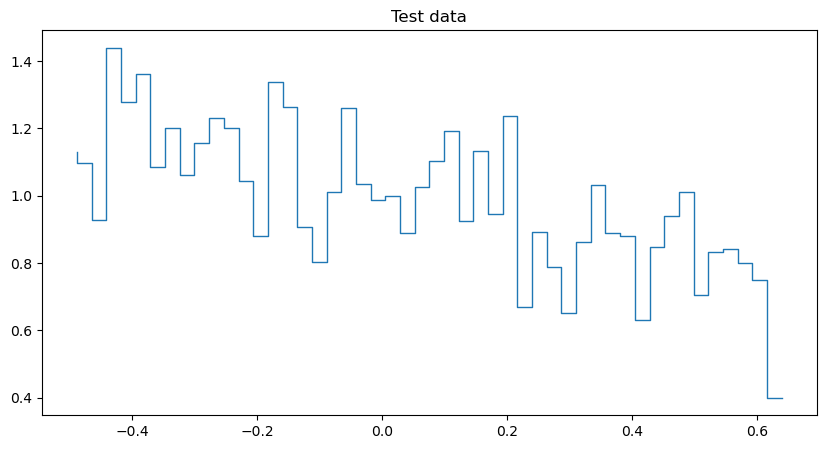

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

hist_test_kpca_2_3b, _ = np.histogram(q_repr_test_kpca_2[is_3b_test_sample_2], bins=kpca_range, density=False)
hist_test_kpca_2_4b, _ = np.histogram(q_repr_test_kpca_2[is_4b_test_sample_2], bins=kpca_range, density=False)

ax.step(kpca_range[:-1], hist_test_kpca_2_4b / hist_test_kpca_2_3b, linewidth=1)
ax.set_title("Test data")

plt.show()
plt.close()